In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
from scipy import signal
import scipy
import pandas as pd
import sys

sys.path.append("../pytorch-unet-segmentation-master/src/")
sys.path.append("../pytorch-unet-segmentation-master/scripts/")
from save_history import *
from modules import *
from dataset import *
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import PostprocesamientoTif
import LoadDatasetTif
import LoadCZI
import CreatePNG_TIF
import PreprocesamientoTif
import Tracking
import TrackingConCelulasBorde

<IPython.core.display.Javascript object>


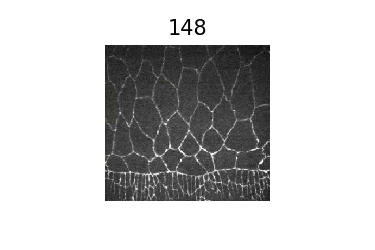

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from PIL import Image
import numpy as np
path0="../pytorch-unet-segmentation-master/archivosTif/cell pulses.tif"
im = Image.open(path0) 
imarray = []
for i in range(im.n_frames):
    im.seek(i)
    imarray.append(np.array(im))
fig, ax = plt.subplots(figsize=(3, 2), tight_layout=True)
def update_plot(k):
    ax.cla()
    ax.imshow(imarray[k])
    ax.axis('off')
    ax.set_title(k)
FuncAnimation(fig, update_plot, frames=len(imarray), repeat=False, interval=50)

In [4]:
path1="../pytorch-unet-segmentation-master/Tif_png/test"
CreatePNG_TIF.png(path1,imarray) #str(1).zfill(3)

In [5]:
pathRead='../pytorch-unet-segmentation-master/Tif_png/test/'
pathLoad="../pytorch-unet-segmentation-master/preprocesadaTif/test/"
OrigiANDPrepro=PreprocesamientoTif.preprocesing(pathRead,pathLoad,len(imarray))
original=OrigiANDPrepro[0] #original
preprocesada=OrigiANDPrepro[1] #preprocesada

<IPython.core.display.Javascript object>


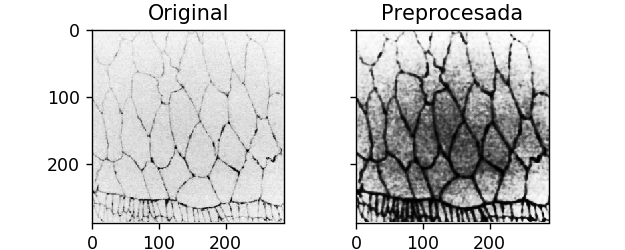

Text(0.5,1,'Preprocesada')

In [6]:
img_num=5
fig, ax = plt.subplots(1, 2, figsize=(5, 2), sharex=True, sharey=True)
ax[0].imshow(original[img_num], cmap=plt.cm.Greys)
ax[0].set_title('Original')
ax[1].imshow(preprocesada[img_num], cmap=plt.cm.Greys)
ax[1].set_title('Preprocesada')

In [7]:
path="../pytorch-unet-segmentation-master/preprocesadaTif"
claudio_loader= LoadDatasetTif.loadData(path)
modelo= '../pytorch-unet-segmentation-master/modelos/model_epoch_440.pwf'
paramThresh = 0.1 #parametro visto en reu
water = PostprocesamientoTif.postprocesing(claudio_loader, modelo, paramThresh)

In [8]:
image=water[0] #imagen con padd
output=water[1] #mascara binaria
img_list=water[2] #lista mascaras binarias
water_list=water[3] #lista imagens watershed
watershed=water[4] #funcion watershed

<IPython.core.display.Javascript object>


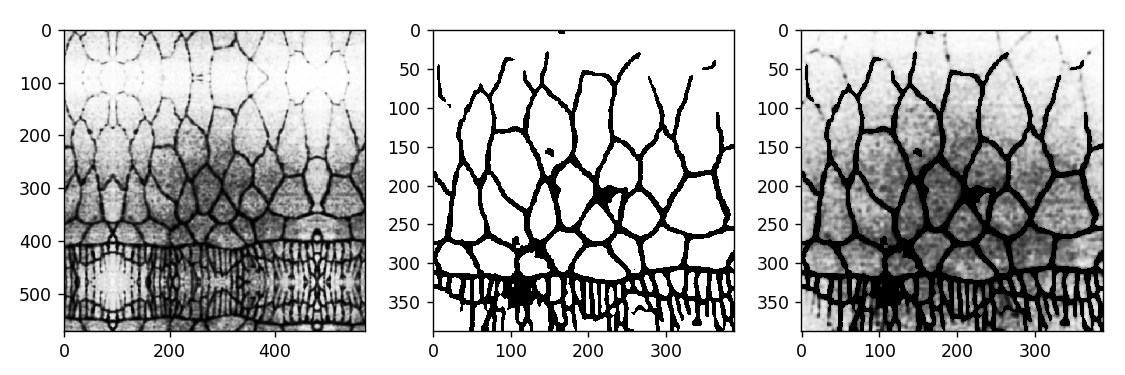

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
pad = (572-388)//2
ax[0].imshow(image.numpy()[0, 0], cmap=plt.cm.Greys_r)
ax[1].imshow(output.numpy()[0], cmap=plt.cm.Greys_r)
borders_on_top = image.numpy()[0, 0, pad:-pad, pad:-pad].copy()
idx = np.where(output.numpy()[0].astype(int) == 0)
borders_on_top[idx[0], idx[1]] = 0
ax[2].imshow(borders_on_top, cmap=plt.cm.Greys_r)

<IPython.core.display.Javascript object>


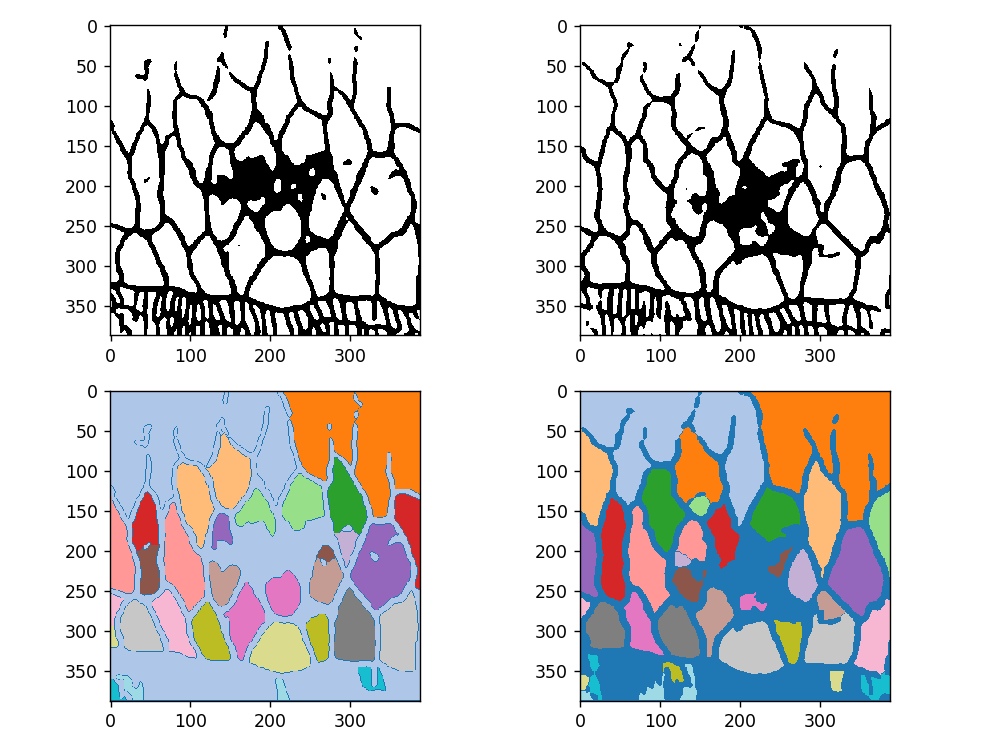

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
ax[0, 0].imshow(img_list[0], cmap=plt.cm.Greys_r)
ax[1, 0].imshow(water_list[0], cmap=plt.cm.tab20)
ax[0, 1].imshow(img_list[13], cmap=plt.cm.Greys_r)
ax[1, 1].imshow(water_list[13], cmap=plt.cm.tab20)

In [11]:
cell_idx = 13 #celula a trackear
paramDist= 800
tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx,paramDist)

In [12]:
cell_idx_history= tracking[0] #historia de posiciones de la celula
new_size_cell = tracking[1] #tamaño de la celula
closestList=tracking[2]

<IPython.core.display.Javascript object>


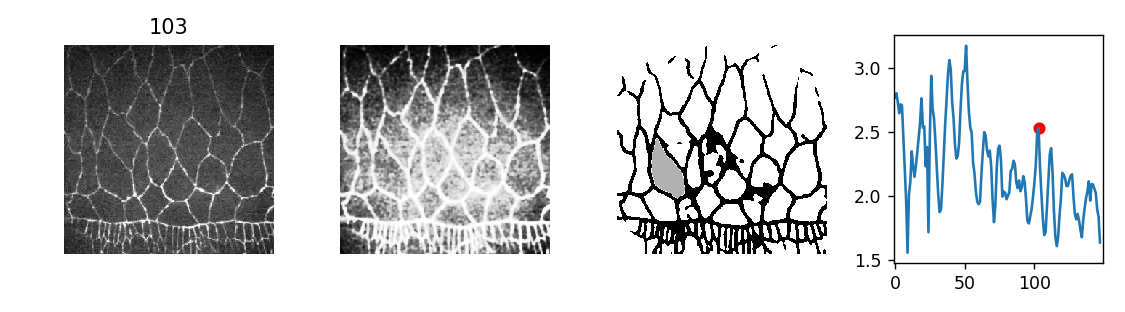

In [13]:
from matplotlib.animation import FuncAnimation, writers

fig, ax = plt.subplots(1, 4, figsize=(9, 2.5), tight_layout=True)
ax[-1].plot(new_size_cell)
ax[-1].set_xlim([-1, 149])
dot = ax[-1].scatter(0, new_size_cell[0], marker='o', color='r')

def update_plot(k):
    for ax_ in ax[:3]:
        ax_.cla()
        ax_.axis('off')
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    ax[0].set_title(k)
    ax[0].imshow(original[k], cmap=plt.cm.Greys_r)
    ax[1].imshow(preprocesada[k], cmap=plt.cm.Greys_r)
    #ax[1].imshow(claudio_loader.dataset[k][0][0].numpy(), cmap=plt.cm.Greys_r)
    ax[2].imshow(img, cmap=plt.cm.Greys_r)
    dot.set_offsets([k, new_size_cell[k]])
    
ani = FuncAnimation(fig, update_plot, frames=len(new_size_cell), repeat=False, interval=500)

<IPython.core.display.Javascript object>


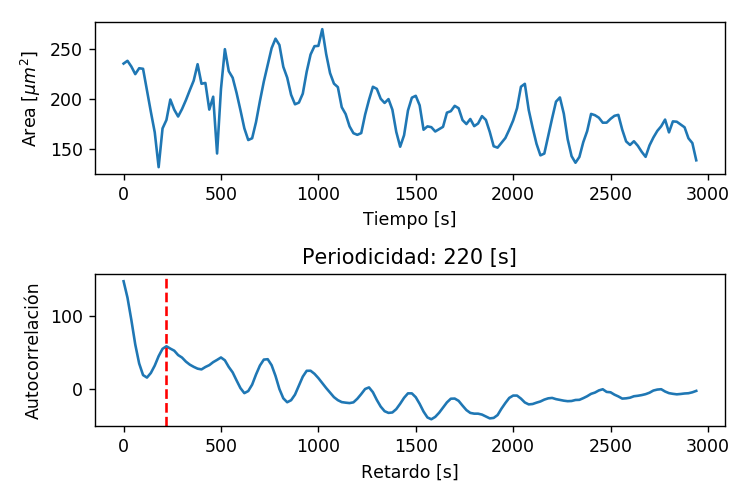

In [15]:
from scipy.signal import argrelextrema

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

relarea2micras = np.prod(water_list[0].shape)*0.2374839**2/100
area = np.array(new_size_cell)*relarea2micras
times = np.arange(len(area))*20
rho = autocorr((area - np.mean(area))/np.std(area))
local_max_idx = argrelextrema(rho, np.greater)[0]
best_local_max_idx = local_max_idx[np.argsort(rho[local_max_idx])][::-1][0]

fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)
ax[0].plot(times, area)
ax[0].set_ylabel(r'Area [$\mu m^2$]')
ax[0].set_xlabel('Tiempo [s]')
ax[1].plot(times, rho)
ax[1].set_ylabel('Autocorrelación')
ax[1].set_xlabel('Retardo [s]')
ax[1].axvline(times[best_local_max_idx], ls='--', c='r')
ax[1].set_title(f'Periodicidad: {times[best_local_max_idx]} [s]');

<IPython.core.display.Javascript object>


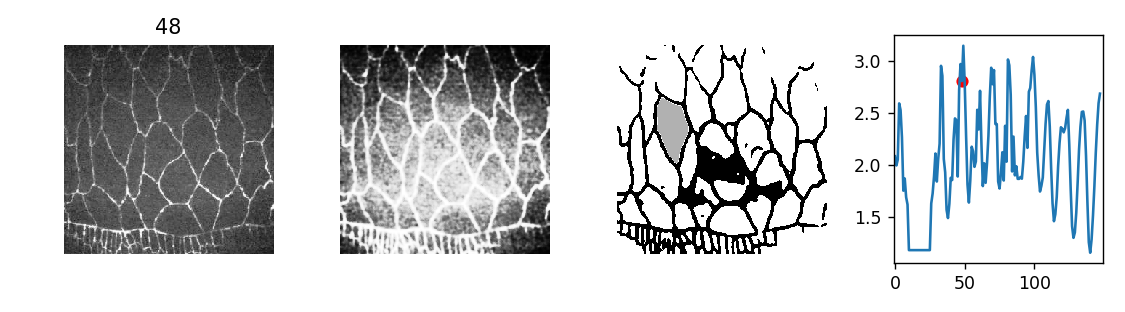

In [17]:
cell_idx = 6 #celula a trackear
paramDist= 800
tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx,paramDist)
cell_idx_history= tracking[0] #historia de posiciones de la celula
new_size_cell = tracking[1] #tamaño de la celula
closestList=tracking[2]
from matplotlib.animation import FuncAnimation, writers

fig, ax = plt.subplots(1, 4, figsize=(9, 2.5), tight_layout=True)
ax[-1].plot(new_size_cell)
ax[-1].set_xlim([-1, 149])
dot = ax[-1].scatter(0, new_size_cell[0], marker='o', color='r')

def update_plot(k):
    for ax_ in ax[:3]:
        ax_.cla()
        ax_.axis('off')
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    ax[0].set_title(k)
    ax[0].imshow(original[k], cmap=plt.cm.Greys_r)
    ax[1].imshow(preprocesada[k], cmap=plt.cm.Greys_r)
    #ax[1].imshow(claudio_loader.dataset[k][0][0].numpy(), cmap=plt.cm.Greys_r)
    ax[2].imshow(img, cmap=plt.cm.Greys_r)
    dot.set_offsets([k, new_size_cell[k]])
    
ani = FuncAnimation(fig, update_plot, frames=len(new_size_cell), repeat=False, interval=500)

<IPython.core.display.Javascript object>


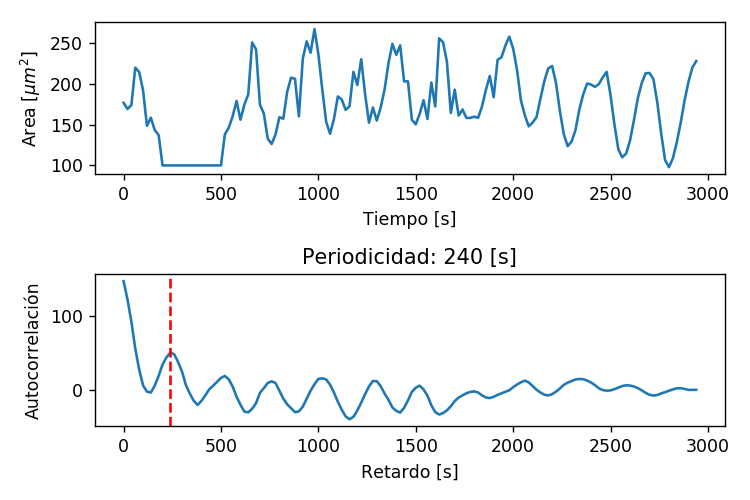

In [18]:
from scipy.signal import argrelextrema

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

relarea2micras = np.prod(water_list[0].shape)*0.2374839**2/100
area = np.array(new_size_cell)*relarea2micras
times = np.arange(len(area))*20
rho = autocorr((area - np.mean(area))/np.std(area))
local_max_idx = argrelextrema(rho, np.greater)[0]
best_local_max_idx = local_max_idx[np.argsort(rho[local_max_idx])][::-1][0]

fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)
ax[0].plot(times, area)
ax[0].set_ylabel(r'Area [$\mu m^2$]')
ax[0].set_xlabel('Tiempo [s]')
ax[1].plot(times, rho)
ax[1].set_ylabel('Autocorrelación')
ax[1].set_xlabel('Retardo [s]')
ax[1].axvline(times[best_local_max_idx], ls='--', c='r')
ax[1].set_title(f'Periodicidad: {times[best_local_max_idx]} [s]');

<IPython.core.display.Javascript object>


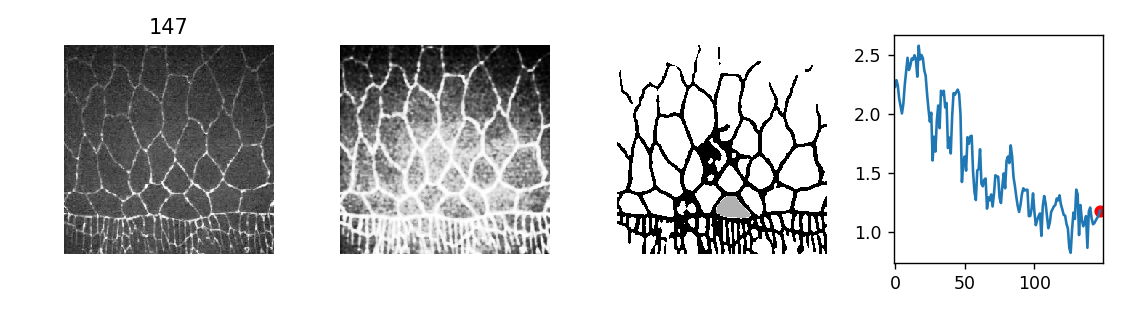

In [21]:
cell_idx = 30 #celula a trackear
paramDist= 800
tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx,paramDist)
cell_idx_history= tracking[0] #historia de posiciones de la celula
new_size_cell = tracking[1] #tamaño de la celula
closestList=tracking[2]
from matplotlib.animation import FuncAnimation, writers

fig, ax = plt.subplots(1, 4, figsize=(9, 2.5), tight_layout=True)
ax[-1].plot(new_size_cell)
ax[-1].set_xlim([-1, 149])
dot = ax[-1].scatter(0, new_size_cell[0], marker='o', color='r')

def update_plot(k):
    for ax_ in ax[:3]:
        ax_.cla()
        ax_.axis('off')
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    ax[0].set_title(k)
    ax[0].imshow(original[k], cmap=plt.cm.Greys_r)
    ax[1].imshow(preprocesada[k], cmap=plt.cm.Greys_r)
    #ax[1].imshow(claudio_loader.dataset[k][0][0].numpy(), cmap=plt.cm.Greys_r)
    ax[2].imshow(img, cmap=plt.cm.Greys_r)
    dot.set_offsets([k, new_size_cell[k]])
    
ani = FuncAnimation(fig, update_plot, frames=len(new_size_cell), repeat=False, interval=200)

<IPython.core.display.Javascript object>


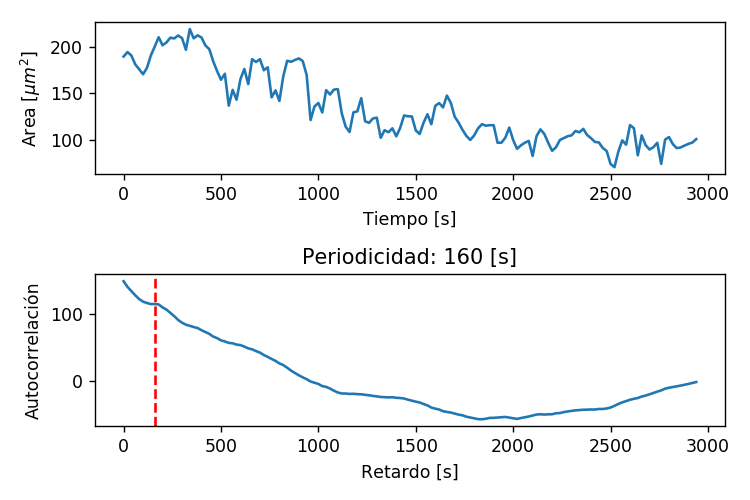

In [22]:
from scipy.signal import argrelextrema

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

relarea2micras = np.prod(water_list[0].shape)*0.2374839**2/100
area = np.array(new_size_cell)*relarea2micras
times = np.arange(len(area))*20
rho = autocorr((area - np.mean(area))/np.std(area))
local_max_idx = argrelextrema(rho, np.greater)[0]
best_local_max_idx = local_max_idx[np.argsort(rho[local_max_idx])][::-1][0]

fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)
ax[0].plot(times, area)
ax[0].set_ylabel(r'Area [$\mu m^2$]')
ax[0].set_xlabel('Tiempo [s]')
ax[1].plot(times, rho)
ax[1].set_ylabel('Autocorrelación')
ax[1].set_xlabel('Retardo [s]')
ax[1].axvline(times[best_local_max_idx], ls='--', c='r')
ax[1].set_title(f'Periodicidad: {times[best_local_max_idx]} [s]');

<IPython.core.display.Javascript object>


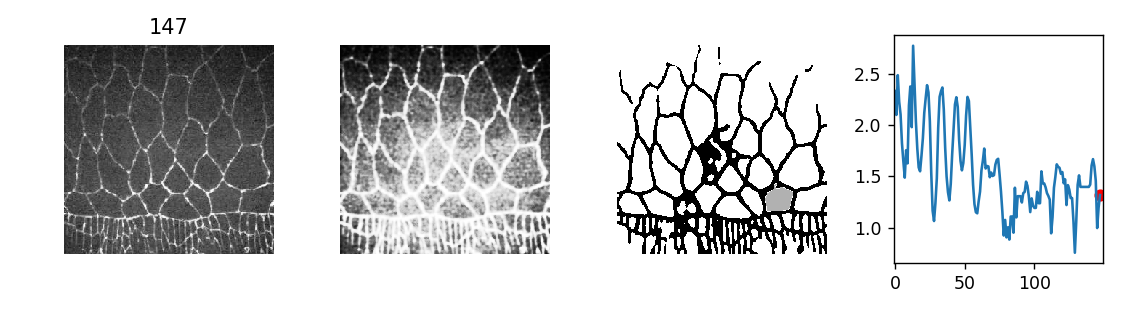

In [23]:
cell_idx = 25 #celula a trackear
paramDist= 800
tracking = Tracking.vecinosMasCercanos(watershed,water_list,cell_idx,paramDist)
cell_idx_history= tracking[0] #historia de posiciones de la celula
new_size_cell = tracking[1] #tamaño de la celula
closestList=tracking[2]
from matplotlib.animation import FuncAnimation, writers

fig, ax = plt.subplots(1, 4, figsize=(9, 2.5), tight_layout=True)
ax[-1].plot(new_size_cell)
ax[-1].set_xlim([-1, 149])
dot = ax[-1].scatter(0, new_size_cell[0], marker='o', color='r')

def update_plot(k):
    for ax_ in ax[:3]:
        ax_.cla()
        ax_.axis('off')
    img = img_list[k].copy()
    img[water_list[k]==cell_idx_history[k]] = 150
    ax[0].set_title(k)
    ax[0].imshow(original[k], cmap=plt.cm.Greys_r)
    ax[1].imshow(preprocesada[k], cmap=plt.cm.Greys_r)
    #ax[1].imshow(claudio_loader.dataset[k][0][0].numpy(), cmap=plt.cm.Greys_r)
    ax[2].imshow(img, cmap=plt.cm.Greys_r)
    dot.set_offsets([k, new_size_cell[k]])
    
ani = FuncAnimation(fig, update_plot, frames=len(new_size_cell), repeat=False, interval=200)

<IPython.core.display.Javascript object>


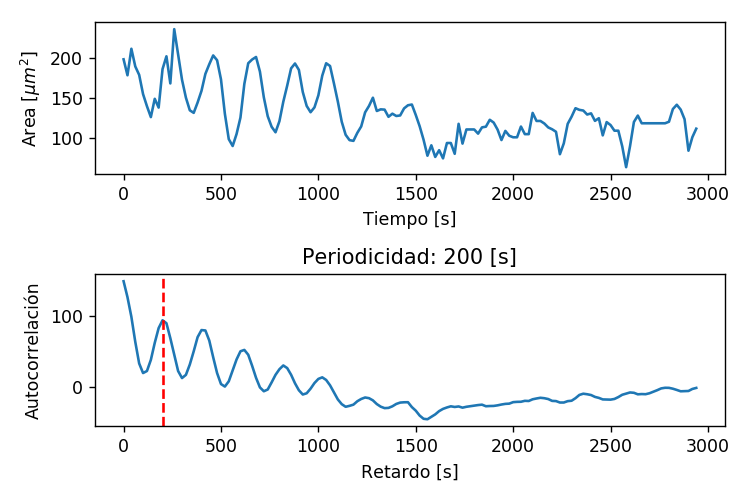

In [24]:
from scipy.signal import argrelextrema

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

relarea2micras = np.prod(water_list[0].shape)*0.2374839**2/100
area = np.array(new_size_cell)*relarea2micras
times = np.arange(len(area))*20
rho = autocorr((area - np.mean(area))/np.std(area))
local_max_idx = argrelextrema(rho, np.greater)[0]
best_local_max_idx = local_max_idx[np.argsort(rho[local_max_idx])][::-1][0]

fig, ax = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True)
ax[0].plot(times, area)
ax[0].set_ylabel(r'Area [$\mu m^2$]')
ax[0].set_xlabel('Tiempo [s]')
ax[1].plot(times, rho)
ax[1].set_ylabel('Autocorrelación')
ax[1].set_xlabel('Retardo [s]')
ax[1].axvline(times[best_local_max_idx], ls='--', c='r')
ax[1].set_title(f'Periodicidad: {times[best_local_max_idx]} [s]');